In [1]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split,RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [2]:
%ls

Classification.ipynb     cats_vs_dogs.ipynb       test1/
HandRight.csv            fashion-mnist_test.csv   test1.zip
HandsSync.ipynb          fashion-mnist_train.csv  train/
HandsTraining/           fmnist.ipynb             train.zip
HandsValidation/         models/                  winequality-red.csv
README.md                sampleSubmission.csv


# Are the Hands in sync ?

<div>
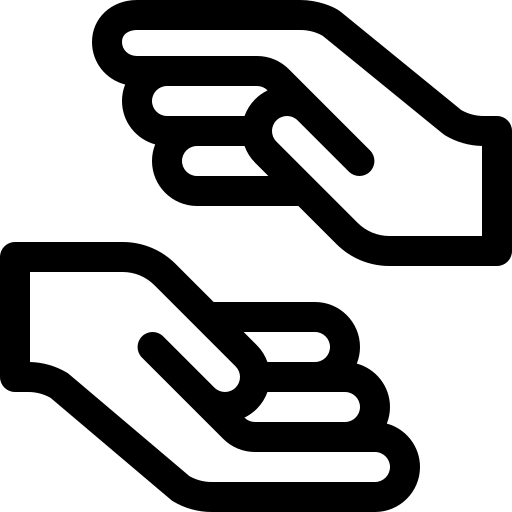
</div>


Hey, this notebook is about checking whether we can predict if the person is moving their hands spotanously in sync with someone or alone

The instruction that were given for the data pre processing:

1. in the directories with duplicate files delete the files that appear first
2. load the righthand data and merge it with each `alone` dataset 
3. creates labels and try to predict the state of the hands

In [46]:
rightHandData = pd.read_csv('./HandRight.csv')
rightHandData.columns = rightHandData.columns.str.strip()
rightHandData

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,128.2883,15478,right,1,15.671670,226.2064,20.264700,34.26665,-195.214700,-35.043020,...,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
1,128.3048,15480,right,1,16.241190,222.9389,20.117810,36.16443,-180.093900,-4.052799,...,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0
2,128.3218,15482,right,1,16.724610,220.9709,19.949720,26.35298,-95.088190,-11.157620,...,-0.278792,48.15030,204.5182,86.35149,204.6231,45.35921,236.8544,0.0,0.281134,0.0
3,128.3384,15484,right,1,17.090160,219.7124,19.676790,19.46804,-61.755180,-21.303780,...,-0.279768,48.64175,203.9989,86.16056,204.9939,44.18692,236.0927,0.0,0.277691,0.0
4,128.3551,15486,right,1,17.460170,219.3652,19.131280,21.94964,-8.355943,-35.081790,...,-0.278629,48.93135,203.3777,85.59017,204.5952,42.68003,235.2896,0.0,0.283008,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807,208.1942,24687,right,1,-15.404800,208.0276,9.980799,167.86240,510.085200,-105.529500,...,-0.282299,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.503490,0.0
4808,208.2108,24689,right,1,-12.678650,218.1196,9.314082,145.00970,562.359400,-20.707010,...,-0.263492,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.403687,0.0
4809,208.2276,24691,right,1,-9.643562,228.2807,9.722980,180.42160,591.901900,28.880570,...,-0.234336,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.310940,0.0
4810,208.2443,24692,right,1,-7.980715,233.5056,10.419080,192.45930,604.734400,80.566980,...,-0.222084,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.286526,0.0


In [47]:
# as we were told we need to get rid of the first 7 seconds
def clean_initial_data(df):
    firsrtTimestamp = df.head(1)["Time"][0]
    df.drop(df[df.Time < firsrtTimestamp+7].index, inplace=True)



In [48]:
clean_initial_data(rightHandData)
rightHandData.drop(rightHandData[rightHandData["Hand Type"]=='left'].index, inplace=True)
rightHandData.drop(['# hands'], axis=1, inplace=True)
rightHandData.reset_index(drop=True)
rightHandData["Hand Type"].value_counts()

right    4317
Name: Hand Type, dtype: int64

In [49]:
rightHandData.dropna(inplace=True)
rightHandData.isnull().sum(axis = 0)

Time              0
Frame ID          0
Hand Type         0
Position X        0
Position Y        0
Position Z        0
Velocity X        0
Velocity Y        0
Velocity Z        0
Pitch             0
Roll              0
Yaw               0
Wrist Pos X       0
Wrist Pos Y       0
Wrist Pos Z       0
Elbow pos X       0
Elbow Pos Y       0
Elbow Pos Z       0
Grab Strenth      0
Grab Angle        0
Pinch Strength    0
dtype: int64

In [7]:
# get 15% percent of the righthand data to be used as test data 
data_percentile = round(len(rightHandData) * 0.2)

separated_test_data = pd.DataFrame.copy(rightHandData.iloc[-data_percentile:])

rightHandData = pd.DataFrame.copy(rightHandData.iloc[:-data_percentile])

rightHandData

,Time,Frame ID,Hand Type,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
421,135.3024,16287,right,11.930320,199.9861,4.981665,-35.512210,-165.34660,-57.68153,-0.092033,...,-0.906612,75.45740,206.0521,45.38764,284.3946,140.016700,201.9318,0.0,0.561324,0.0
422,135.3194,16289,right,11.191900,195.3075,3.661716,-43.587440,-309.83740,-77.18515,-0.111674,...,-0.904311,74.46141,202.4562,44.28679,282.6278,140.971200,203.6773,0.0,0.626321,0.0
423,135.3357,16291,right,10.533080,189.0297,2.829388,-30.403600,-363.00330,-43.79815,-0.140004,...,-0.901862,73.60060,197.4387,43.54082,280.6384,142.540100,206.7526,0.0,0.636596,0.0
424,135.3524,16293,right,10.243000,181.9816,2.064330,-15.424000,-423.21200,-43.99948,-0.166623,...,-0.901268,73.19537,191.7202,42.73155,279.7357,148.138200,209.9330,0.0,0.701644,0.0
425,135.3690,16295,right,10.020610,174.8592,1.228467,-8.733602,-413.45130,-53.88054,-0.197763,...,-0.897777,72.68671,186.1613,41.98006,278.6890,152.521500,212.1112,0.0,0.786548,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3602,187.9682,22358,right,15.011520,227.8607,-3.997064,-98.245350,197.21200,319.55200,1.111313,...,-0.046356,28.75041,164.1245,36.46899,136.5801,1.873683,226.2796,0.0,0.534085,0.0
3603,187.9847,22360,right,12.565540,232.2578,-1.452736,-185.950000,224.99400,77.43333,1.191593,...,-0.134248,27.88593,166.7243,35.27282,138.2208,9.605652,227.9398,0.0,0.509543,0.0
3604,188.0015,22362,right,9.757510,234.7574,-0.994918,-139.169100,74.02553,41.39766,1.210409,...,-0.233767,27.12279,169.1516,34.70261,139.2601,11.057680,225.5223,0.0,0.457348,0.0
3605,188.0176,22364,right,7.025321,234.3546,-0.467190,-150.620900,35.70984,38.94785,1.180323,...,-0.264282,26.00730,169.8926,36.53437,144.7947,13.031930,224.3239,0.0,0.436348,0.0


## The labels of each type are as follows:

Alone: 0

Sync: 1

Spontan: 2

In [75]:
def prep_alone_data(df):
    df = pd.DataFrame.copy(df)
    right_hand_copy = pd.DataFrame.copy(rightHandData)
    
    min_index_val = min(df.index.size, right_hand_copy.index.size)

    
    df.drop(df[df["Hand Type"]=='right'].index, inplace=True)
    df = df.truncate(after=min_index_val-1)
    df = df.reset_index()
    
    right_hand_copy = right_hand_copy.truncate(after=df.index.size-1)
    right_hand_copy = right_hand_copy.reset_index()

    
    right_hand_copy["Frame ID"] = df["Frame ID"]
    right_hand_copy["Time"] = df["Time"]

    combined_df = right_hand_copy.append(df)

    return combined_df

In [76]:
def get_df_list(path_to_scan):   
    csv_train_data_list = []
    for filename in glob.iglob(path_to_scan, recursive=True):

        cleansed_name = filename.split('/')[-1].split('.')[0].lower()

        data = pd.read_csv(filename)
        data.columns = data.columns.str.strip()
        clean_initial_data(data)
        if '# hands' in data.columns:
            data.drop(['# hands'], axis=1, inplace=True)

        if 'alone' in cleansed_name:

            data = prep_alone_data(data)
            data['type'] = 0

        if 'sync' in cleansed_name:
            data['type'] = 1

        if 'spontan' in cleansed_name:
            data['type'] = 2
        

        csv_train_data_list.append(data.sort_values(by=["Time"]))
    return csv_train_data_list

### clearing these columns for each dataframe since they don't give us any value

In [77]:
csv_data_list = get_df_list('./HandsTraining/**/*.csv')

In [78]:
to_clear = {'Frame ID', 'type'}

def clear_columns(df):
    for column_name in df:
        column_prefix = column_name.split('_')[0]
        if column_prefix in to_clear:
            df[column_prefix] = df[column_name]
            df.drop([column_name], axis=1, inplace=True)

### this function is meant to flatten the data after the groupby operation so that we have the right and left hand data on the same row

In [84]:

cleansed_data = []

def flatten_df(df):

    df["Time"] = df["Time"].round(1)


    temp_df = data.groupby(["Time","Hand Type"]).mean().unstack()
    
    print(temp_df[temp_df.columns[temp_df.isnull().any()]])
    
    temp_df.columns = [f"{x}_{y}" for x, y in temp_df.columns.to_flat_index()]
    clear_columns(temp_df)

    temp_df = temp_df.reset_index()
    return temp_df


for data in csv_data_list:
    cleansed_data.append(flatten_df(data))


           index      Frame ID Position X Position Y Position Z Velocity X  \
Hand Type  right         right      right      right      right      right   
Time                                                                         
619.9      421.5  71526.000000  11.561110  197.64680   4.321691 -39.549825   
620.0      425.5  71533.666667  10.209380  172.03120   0.638263  -4.644668   
620.1      431.5  71545.000000   8.626778  154.24655  -6.222635 -39.175324   
620.2      437.5  71556.500000   2.352101  188.94805 -15.967013 -65.219663   
620.3      443.5  71568.000000  -3.693207  239.02375 -20.750805 -52.908467   
...          ...           ...        ...        ...        ...        ...   
678.4        NaN           NaN        NaN        NaN        NaN        NaN   
678.5        NaN           NaN        NaN        NaN        NaN        NaN   
678.6        NaN           NaN        NaN        NaN        NaN        NaN   
678.7        NaN           NaN        NaN        NaN        NaN 

               Frame ID  Position X  Position Y Position Z  Velocity X  \
Hand Type         right       right       right      right       right   
Time                                                                     
568.7      66240.000000  132.940100  124.099900  32.833670  -12.172370   
568.8      66246.166667  130.517433  113.918850  34.015210  -41.168462   
568.9      66258.000000  128.569950  109.284633  34.066447  -13.824904   
569.0      66269.166667  129.944050  124.645233  34.175957   39.794533   
569.1      66281.714286  132.289157  167.309214  33.780824    9.328370   
...                 ...         ...         ...        ...         ...   
636.3      74016.000000  132.100383  148.467283 -42.032960 -115.480535   
636.4      74027.333333  119.987550  163.171567 -26.393002  -61.839708   
636.5      74039.000000  119.285833  187.578517   3.210523   42.351310   
636.6      74050.000000  122.353533  200.987850  15.183600   35.639438   
636.7      74060.000000  134.456425  2

               Frame ID                Position X              Position Y  \
Hand Type          left         right        left       right        left   
Time                                                                        
605.6      45853.000000  45853.000000  -78.740750  129.365500  180.242100   
605.7      45859.000000  45859.000000  -78.437453  134.571800  180.030033   
605.8      45868.000000  45868.000000  -80.013200  148.488400  182.970100   
605.9      45877.000000  45877.000000  -78.750767  153.843667  172.312967   
606.0      45886.000000  45886.000000  -79.575780  155.655333  170.057133   
...                 ...           ...         ...         ...         ...   
673.2      52480.000000  52480.000000 -118.061233  128.500200  231.987600   
673.3      52491.000000  52491.000000 -111.415100  136.961533  235.958833   
673.4      52501.666667  52501.666667  -96.497757  143.341167  232.605433   
673.5      52512.333333  52512.333333  -82.373880  154.556833  203.331733   

           index      Frame ID Position X  Position Y Position Z Velocity X  \
Hand Type  right         right      right       right      right      right   
Time                                                                          
394.0      423.5  45947.000000  10.673197  184.833950   2.514122 -20.453534   
394.1      429.5  45958.833333   9.688317  154.365500  -3.636805 -15.540938   
394.2      435.5  45970.000000   4.662556  172.918867 -12.680973 -64.701307   
394.3      441.5  45981.500000  -1.938509  223.755517 -20.281010 -57.553383   
394.4      447.5  45993.000000  -6.337081  264.267183 -18.774188 -31.083887   
...          ...           ...        ...         ...        ...        ...   
452.0        NaN           NaN        NaN         NaN        NaN        NaN   
452.1        NaN           NaN        NaN         NaN        NaN        NaN   
452.2        NaN           NaN        NaN         NaN        NaN        NaN   
452.3        NaN           NaN        NaN         Na

In [13]:
len(cleansed_data)

27

### The custom split train test 

we are going to take the last 7 seconds of each dataframe and remove the initial 2 seconds. to 'confuse' the model

In [14]:
def split_label_from_data(df, label_column):
    label = df[label_column]
    data_without_label = df.drop([label_column], axis=1)
    
    return data_without_label, label

In [15]:
def custom_split_train_test():
    validation_set = pd.DataFrame()
    train_set = pd.DataFrame()
    for clean_df in cleansed_data:
        sorted_by_time = clean_df.sort_values(by=["Time"])
        last_timestamp = sorted_by_time.iloc[-1]["Time"]
        chunk_start_timestamp = last_timestamp - 7
        
        train_set = train_set.append(sorted_by_time[sorted_by_time["Time"]< chunk_start_timestamp])
        validation_set = validation_set.append(sorted_by_time[sorted_by_time["Time"]> chunk_start_timestamp +2 ])
        

    return train_set, validation_set

In [16]:
trainush, testush = custom_split_train_test()

x_train, x_label = split_label_from_data(trainush, 'type')
y_test, y_label = split_label_from_data(testush,'type')


In [18]:
x_train.sort_values(by=["Time"])

,Time,Position X_left,Position X_right,Position Y_left,Position Y_right,Position Z_left,Position Z_right,Velocity X_left,Velocity X_right,Velocity Y_left,...,Elbow Pos Y_right,Elbow Pos Z_left,Elbow Pos Z_right,Grab Strenth_left,Grab Strenth_right,Grab Angle_left,Grab Angle_right,Pinch Strength_left,Pinch Strength_right,Frame ID
0,182.5,-161.930300,164.727000,215.807400,207.843200,99.368170,-41.853090,12.804610,31.496850,-43.177220,...,15.955520,133.742300,134.076600,0.0,0.0,0.567723,1.476075,0.0,1.000000,21577.000000
1,182.6,-161.147333,163.927783,213.452300,203.887133,90.860963,-41.826777,17.149331,-23.558522,-47.061282,...,19.178312,139.766500,135.583950,0.0,0.0,0.546890,1.453950,0.0,1.000000,21583.333333
2,182.7,-161.367183,161.622367,212.712783,202.655617,79.356038,-41.185242,2.794853,25.431545,-10.445506,...,26.445363,121.489217,136.369283,0.0,0.0,0.463742,1.043665,0.0,0.843672,21595.000000
3,182.8,-160.212133,171.312883,209.000500,197.852917,70.577410,-34.986755,18.645327,113.604802,-50.127768,...,33.942928,124.541350,115.734717,0.0,0.0,0.481226,0.424739,0.0,0.007692,21606.166667
4,182.9,-160.778950,169.838950,206.725667,193.800733,62.673780,-40.994495,-16.685625,-130.244575,-0.858821,...,68.097462,151.022417,89.051430,0.0,0.0,0.300196,0.310966,0.0,0.000000,21617.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,848.8,-58.971737,83.158983,162.788733,181.927700,-8.952480,28.309513,-10.374597,31.579373,40.981663,...,-71.728560,102.036003,174.912367,0.0,0.0,0.000000,0.000000,0.0,0.000000,66850.000000
605,848.9,-61.332230,84.555967,163.177633,184.255833,-13.145833,32.943007,-21.083560,7.641229,-22.398882,...,-49.782687,108.613200,186.145567,0.0,0.0,0.000000,0.000000,0.0,0.000000,66856.000000
606,849.0,-62.376480,84.966260,162.443633,187.095400,-13.533533,35.565343,-0.721314,-1.570378,-2.040718,...,-20.252860,109.676900,203.008700,0.0,0.0,0.000000,0.000000,0.0,0.000000,66862.000000
607,849.1,-61.874540,84.792157,161.297667,186.285900,-13.581497,35.573430,4.859208,2.950866,-10.359607,...,-6.354399,114.030167,215.321567,0.0,0.0,0.000000,0.000000,0.0,0.000000,66867.333333


In [19]:
combined_data = pd.DataFrame()


for clean_df in cleansed_data:

    combined_data = combined_data.append(clean_df)
    
combined_data = combined_data.sort_values(by=["Time"]).reset_index(drop=True)

In [20]:
combined_data

,Time,Position X_left,Position X_right,Position Y_left,Position Y_right,Position Z_left,Position Z_right,Velocity X_left,Velocity X_right,Velocity Y_left,...,Elbow Pos Z_left,Elbow Pos Z_right,Grab Strenth_left,Grab Strenth_right,Grab Angle_left,Grab Angle_right,Pinch Strength_left,Pinch Strength_right,Frame ID,type
0,182.5,-161.930300,164.727000,215.807400,207.843200,99.368170,-41.853090,12.804610,31.496850,-43.177220,...,133.742300,134.076600,0.0,0.0,0.567723,1.476075,0.0,1.000000,21577.000000,2.0
1,182.6,-161.147333,163.927783,213.452300,203.887133,90.860963,-41.826777,17.149331,-23.558522,-47.061282,...,139.766500,135.583950,0.0,0.0,0.546890,1.453950,0.0,1.000000,21583.333333,2.0
2,182.7,-161.367183,161.622367,212.712783,202.655617,79.356038,-41.185242,2.794853,25.431545,-10.445506,...,121.489217,136.369283,0.0,0.0,0.463742,1.043665,0.0,0.843672,21595.000000,2.0
3,182.8,-160.212133,171.312883,209.000500,197.852917,70.577410,-34.986755,18.645327,113.604802,-50.127768,...,124.541350,115.734717,0.0,0.0,0.481226,0.424739,0.0,0.007692,21606.166667,2.0
4,182.9,-160.778950,169.838950,206.725667,193.800733,62.673780,-40.994495,-16.685625,-130.244575,-0.858821,...,151.022417,89.051430,0.0,0.0,0.300196,0.310966,0.0,0.000000,21617.833333,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17096,855.9,-70.453103,90.665587,145.614333,181.009500,-30.040717,7.188007,-43.192437,15.465817,74.020667,...,116.774233,165.119800,0.0,0.0,0.026178,0.000000,0.0,0.000000,67285.000000,1.0
17097,856.0,-75.265617,92.915810,155.741133,186.682833,-24.720013,9.888543,-23.023155,23.277647,100.415487,...,109.050400,161.732467,0.0,0.0,0.000000,0.000000,0.0,0.000000,67290.666667,1.0
17098,856.1,-76.440717,94.843933,165.672500,196.670167,-19.517557,16.651350,-3.741536,19.769600,86.023520,...,118.906167,170.747100,0.0,0.0,0.000000,0.000000,0.0,0.000000,67297.000000,1.0
17099,856.2,-77.523073,97.887433,173.588500,205.986700,-14.190840,30.203363,-31.737673,33.601047,91.164027,...,137.171233,129.948500,0.0,0.0,0.000000,0.000000,0.0,0.000000,67304.000000,1.0


In [21]:
print(combined_data["type"].value_counts())
label = combined_data["type"]
data_without_label = combined_data.drop(['type'], axis=1)

1.0    6112
2.0    6081
0.0    4860
Name: type, dtype: int64


In [22]:
knn_cls = KNeighborsClassifier()
knn_cls.fit(x_train, x_label)

knn_cls.score(y_test, y_label)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=0, n_jobs=-1)


forest_clf.fit(x_train, x_label)
forest_clf.score(y_test, y_label)

## Load test data

In [ ]:
test_df_list = get_df_list(r'./HandsTraining/**/*.csv')